# Importing libraries

In [131]:
import sys
sys.path.insert(1, '/gh/kaggle-pg-3x26')
import zipfile
import pandas as pd

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import pickle
import src.functions as func
import requests
import seaborn as sn
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction import DictVectorizer

In [52]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Getting data

In [4]:
with zipfile.ZipFile("/gh/kaggle-pg-3x26/data/playground-series-s3e26.zip") as z:
    with z.open("sample_submission.csv") as f:
        sample_submission = pd.read_csv(f)
    with z.open("test.csv") as f:
        test = pd.read_csv(f)
    with z.open("train.csv") as f:
        train = pd.read_csv(f)

# Exploring data

In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5271 non-null   int64  
 1   Status_C   5271 non-null   float64
 2   Status_CL  5271 non-null   float64
 3   Status_D   5271 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 164.8 KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

In [8]:
test["id"].min()

7905

In [17]:
train.head(3).T

,0,1,2
id,0,1,2
N_Days,999,2574,3428
Drug,D-penicillamine,Placebo,Placebo
Age,21532,19237,13727
Sex,M,F,F
Ascites,N,N,N
Hepatomegaly,N,N,Y
Spiders,N,N,Y
Edema,N,N,Y
Bilirubin,2.3,0.9,3.3


In [9]:
sample_submission.head(3)

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128


In [10]:
sample_submission["id"].min()

7905

In [11]:
sample_submission[["Status_C","Status_CL","Status_D"]].mean()

Status_C     0.628084
Status_CL    0.034788
Status_D     0.337128
dtype: float64

In [12]:
sample_submission[["Status_C","Status_CL","Status_D"]].min(), sample_submission[["Status_C","Status_CL","Status_D"]].max()

(Status_C     0.628084
 Status_CL    0.034788
 Status_D     0.337128
 dtype: float64,
 Status_C     0.628084
 Status_CL    0.034788
 Status_D     0.337128
 dtype: float64)

In [18]:
train["Status"].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

# One hot encoder in output

In [21]:
cat_encoder = OneHotEncoder(sparse_output=False)


In [23]:
cat_1hot = cat_encoder.fit_transform(train[["Status"]])
cat_1hot

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [25]:
cat_encoder.get_feature_names_out()

array(['Status_C', 'Status_CL', 'Status_D'], dtype=object)

In [26]:
df_output = pd.DataFrame(cat_encoder.transform(train[["Status"]]),
                         columns=cat_encoder.get_feature_names_out(),
                         index=train[["Status"]].index)

In [27]:
df_output.head(3), df_output.tail(3),train[["Status"]].head(3),train[["Status"]].tail(3)

(   Status_C  Status_CL  Status_D
 0       0.0        0.0       1.0
 1       1.0        0.0       0.0
 2       0.0        0.0       1.0,
       Status_C  Status_CL  Status_D
 7902       0.0        0.0       1.0
 7903       0.0        0.0       1.0
 7904       1.0        0.0       0.0,
   Status
 0      D
 1      C
 2      D,
      Status
 7902      D
 7903      D
 7904      C)

In [32]:
train[cat_encoder.get_feature_names_out()] = cat_1hot

In [33]:
train.head(3).T

,0,1,2
id,0,1,2
N_Days,999,2574,3428
Drug,D-penicillamine,Placebo,Placebo
Age,21532,19237,13727
Sex,M,F,F
Ascites,N,N,N
Hepatomegaly,N,N,Y
Spiders,N,N,Y
Edema,N,N,Y
Bilirubin,2.3,0.9,3.3


# Base line model

In [13]:
prediction = func.base_line(train)
prediction

,id,Status_C,Status_CL,Status_D
0,0,0.628084,0.034788,0.337128
1,1,0.628084,0.034788,0.337128
2,2,0.628084,0.034788,0.337128
3,3,0.628084,0.034788,0.337128
4,4,0.628084,0.034788,0.337128
...,...,...,...,...
7900,7900,0.628084,0.034788,0.337128
7901,7901,0.628084,0.034788,0.337128
7902,7902,0.628084,0.034788,0.337128
7903,7903,0.628084,0.034788,0.337128


In [34]:
prediction[["Status_C","Status_CL","Status_D"]].head(1)

,Status_C,Status_CL,Status_D
0,0.628084,0.034788,0.337128


In [35]:

error = log_loss(train[["Status_C","Status_CL","Status_D"]],prediction[["Status_C","Status_CL","Status_D"]])

In [36]:
error

0.7755024047843813

In [37]:
url = 'http://localhost:9695/predict'
customer = {
    "id": 532
}

response = requests.post(url, json=customer).json()
print(response)

{'Status_C': 0.628084, 'Status_CL': 0.034788, 'Status_D': 0.337128, 'id': 532}


In [38]:
prediction = func.base_line(test)

In [39]:
prediction.to_csv("../data/base-line-model-answer.csv",index=False)

In [40]:
# kaggle competitions submit -c playground-series-s3e25 -f submission.csv -m "Message"

# 2nd Model

# Exploring data v2

In [45]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7905.0,NaN,NaN,NaN,3952.0,2282.121272,0.0,1976.0,3952.0,5928.0,7904.0
N_Days,7905.0,NaN,NaN,NaN,2030.173308,1094.233744,41.0,1230.0,1831.0,2689.0,4795.0
Drug,7905,2,Placebo,4010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,7905.0,NaN,NaN,NaN,18373.14649,3679.958739,9598.0,15574.0,18713.0,20684.0,28650.0
Sex,7905,2,F,7336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascites,7905,2,N,7525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hepatomegaly,7905,2,Y,4042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spiders,7905,2,N,5966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edema,7905,3,N,7161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bilirubin,7905.0,NaN,NaN,NaN,2.594485,3.81296,0.3,0.7,1.1,3.0,28.0


In [58]:
categorical_variables = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

In [64]:
train["Status"].value_counts(),train["Status"].value_counts() / train.shape[0]

(Status
 C     4965
 D     2665
 CL     275
 Name: count, dtype: int64,
 Status
 C     0.628083
 D     0.337128
 CL    0.034788
 Name: count, dtype: float64)

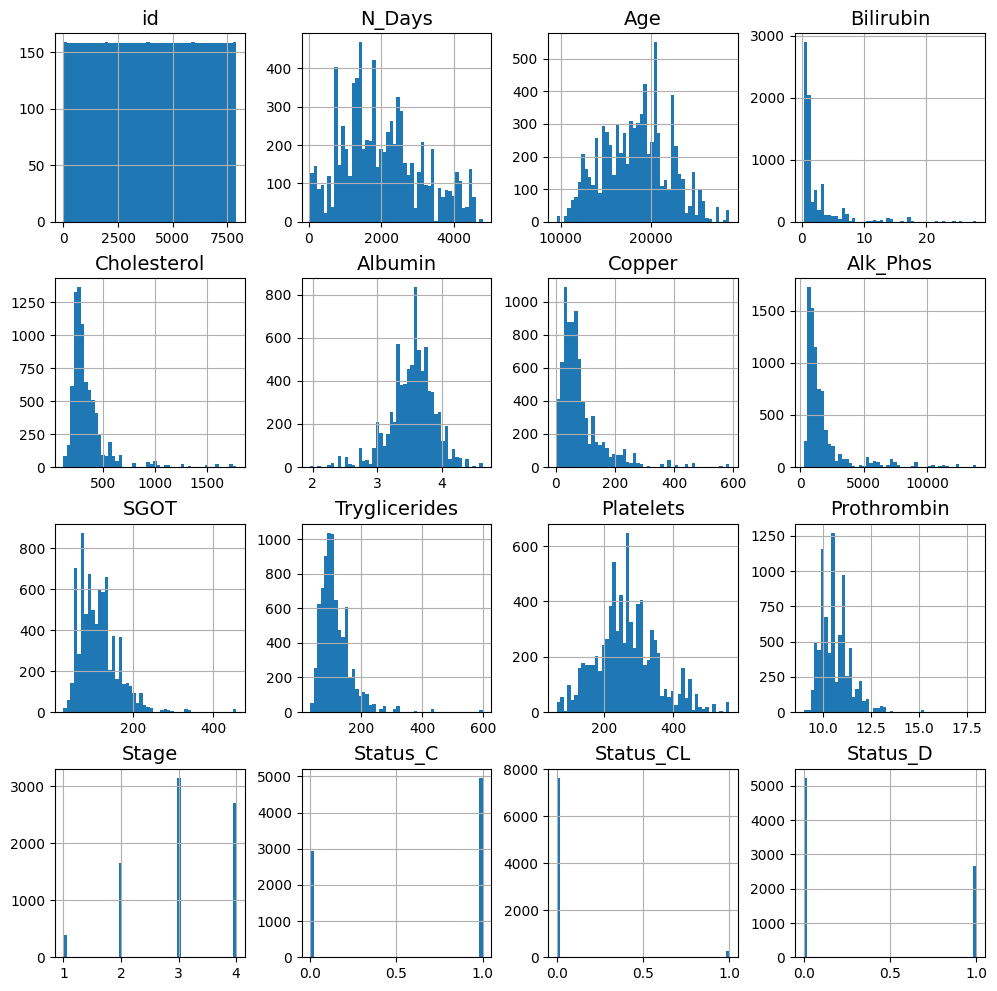

In [55]:
train.hist(bins=50, figsize=(12, 12))
plt.show()

In [83]:
proportion = train.groupby("Status",as_index=False)["id"].count()

In [84]:
proportion.rename({"id":"ori_%"},axis=1,inplace=True)

In [85]:
proportion["ori_%"] = proportion["ori_%"]/train.shape[0]

In [86]:
proportion

,Status,ori_%
0,C,0.628083
1,CL,0.034788
2,D,0.337128


In [87]:
counting = train.groupby(col,as_index=False)["id"].count().rename({"id":"count"},axis=1)
percentage = train.groupby([col,"Status"],as_index=False)["id"].count()
percentage = percentage.merge(counting,how="left",on=col)
percentage.rename({"id":"%"},axis=1,inplace=True)
percentage["%"] = percentage["%"]/percentage["count"]
percentage = percentage.merge(proportion,how="left",on="Status")
percentage

,Edema,Status,%,count,ori_%
0,N,C,0.676861,7161,0.628083
1,N,CL,0.035889,7161,0.034788
2,N,D,0.287250,7161,0.337128
3,S,C,0.275689,399,0.628083
4,S,CL,0.040100,399,0.034788
5,S,D,0.684211,399,0.337128
6,Y,C,0.023188,345,0.628083
7,Y,CL,0.005797,345,0.034788
8,Y,D,0.971014,345,0.337128


In [88]:
for col in categorical_variables:
    counting = train.groupby(col,as_index=False)["id"].count().rename({"id":"count"},axis=1)
    percentage = train.groupby([col,"Status"],as_index=False)["id"].count()
    percentage = percentage.merge(counting,how="left",on=col)
    percentage.rename({"id":"%"},axis=1,inplace=True)
    percentage["%"] = percentage["%"]/percentage["count"]
    percentage = percentage.merge(proportion,how="left",on="Status")
    print(percentage)

              Drug Status         %  count     ori_%
0  D-penicillamine      C  0.617458   3895  0.628083
1  D-penicillamine     CL  0.038768   3895  0.034788
2  D-penicillamine      D  0.343774   3895  0.337128
3          Placebo      C  0.638404   4010  0.628083
4          Placebo     CL  0.030923   4010  0.034788
5          Placebo      D  0.330673   4010  0.337128
  Sex Status         %  count     ori_%
0   F      C  0.645447   7336  0.628083
1   F     CL  0.034215   7336  0.034788
2   F      D  0.320338   7336  0.337128
3   M      C  0.404218    569  0.628083
4   M     CL  0.042179    569  0.034788
5   M      D  0.553603    569  0.337128
  Ascites Status         %  count     ori_%
0       N      C  0.656478   7525  0.628083
1       N     CL  0.035748   7525  0.034788
2       N      D  0.307774   7525  0.337128
3       Y      C  0.065789    380  0.628083
4       Y     CL  0.015789    380  0.034788
5       Y      D  0.918421    380  0.337128
  Hepatomegaly Status         %  count   

In [89]:
important_categorical_variables = ["Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

In [90]:
most_important_categorical_variables = ["Hepatomegaly","Spiders"]

# splitting the data

In [94]:
strat_train_set, strat_test_set = train_test_split(
    train, test_size=0.2, stratify=train["Status"], random_state=42)

In [95]:
strat_test_set.shape

(1581, 23)

# One hot input

In [100]:
cat_encoder2 = OneHotEncoder(sparse_output=False)
cat_1hot2 = cat_encoder2.fit_transform(strat_train_set[most_important_categorical_variables])
strat_train_set[cat_encoder2.get_feature_names_out()] = cat_1hot2

In [101]:
strat_train_set.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status', 'Status_C', 'Status_CL', 'Status_D',
       'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y'],
      dtype='object')

# training

In [107]:
X = strat_train_set[['Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y']].values
y = strat_train_set["Status"].values

In [108]:
X, y

(array([[0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 0.],
        ...,
        [0., 1., 1., 0.],
        [0., 1., 1., 0.],
        [1., 0., 1., 0.]]),
 array(['C', 'C', 'C', ..., 'C', 'D', 'C'], dtype=object))

In [109]:
clf = SGDClassifier(loss="log_loss", max_iter=5,random_state=42)
clf.fit(X, y)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=5, random_state=42)

# Evaluating 2nd model

In [110]:
y_hat = clf.predict_proba(X)

In [111]:
y_hat.shape

(6324, 3)

In [112]:
y_hat

array([[0.22424522, 0.03524554, 0.74050924],
       [0.43318741, 0.04166659, 0.525146  ],
       [0.80177707, 0.03958745, 0.15863548],
       ...,
       [0.43318741, 0.04166659, 0.525146  ],
       [0.43318741, 0.04166659, 0.525146  ],
       [0.80177707, 0.03958745, 0.15863548]])

In [113]:
clf.predict(X)

array(['D', 'D', 'C', ..., 'D', 'D', 'C'], dtype='<U2')

In [114]:
clf.classes_

array(['C', 'CL', 'D'], dtype='<U2')

In [117]:
error = log_loss(strat_train_set[["Status_C","Status_CL","Status_D"]],y_hat)
error

0.6804385961144375

In [120]:
cat_1hot_test = cat_encoder2.transform(strat_test_set[most_important_categorical_variables])
strat_test_set[cat_encoder2.get_feature_names_out()] = cat_1hot_test

In [121]:
X_test = strat_test_set[['Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y']].values
y_test = strat_test_set["Status"].values

In [122]:

y_hat_test = clf.predict_proba(X_test)

In [123]:
error = log_loss(strat_test_set[["Status_C","Status_CL","Status_D"]],y_hat_test)
error

0.69680293443312

# prediction 2nd model

In [124]:
cat_1hot_test_final = cat_encoder2.transform(test[most_important_categorical_variables])
test[cat_encoder2.get_feature_names_out()] = cat_1hot_test_final
X_test_final = test[['Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y']].values
y_hat_test_final = clf.predict_proba(X_test_final)
test[cat_encoder.get_feature_names_out()] = y_hat_test_final

In [130]:
cols = ["id"]+list(cat_encoder.get_feature_names_out())
test[cols].to_csv("../data/2nd-model-answer.csv",index=False)

# preparing deployment

In [133]:
dicts = strat_train_set[['Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y']].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

In [135]:
output_file = '../models/sgd-classifier.bin'
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, clf), f_out)

In [136]:
with open(output_file, 'rb') as f_in: 
    dv2, model = pickle.load(f_in)

In [137]:
customer = {
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'yes',
    'dependents': 'no',
    'phoneservice': 'no',
    'multiplelines': 'no_phone_service',
    'internetservice': 'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'yes',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 29.85,
    'totalcharges': 29.85
}

In [138]:
X = dv2.transform([customer])

In [139]:
y_pred = model.predict_proba(X)

In [140]:
print('input:', customer)
print('output:', y_pred)

input: {'gender': 'female', 'seniorcitizen': 0, 'partner': 'yes', 'dependents': 'no', 'phoneservice': 'no', 'multiplelines': 'no_phone_service', 'internetservice': 'dsl', 'onlinesecurity': 'no', 'onlinebackup': 'yes', 'deviceprotection': 'no', 'techsupport': 'no', 'streamingtv': 'no', 'streamingmovies': 'no', 'contract': 'month-to-month', 'paperlessbilling': 'yes', 'paymentmethod': 'electronic_check', 'tenure': 1, 'monthlycharges': 29.85, 'totalcharges': 29.85}
output: [[0.6042719 0.0240157 0.3717124]]


In [1]:
import requests
customer = {
    "id":532,
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'yes',
    'dependents': 'no',
    'phoneservice': 'no',
    'multiplelines': 'no_phone_service',
    'internetservice': 'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'yes',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 29.85,
    'totalcharges': 29.85
}

url = 'http://localhost:9695/predict'

response = requests.post(url, json=customer).json()
print(response)

{'Status_C': 0.6042718970156338, 'Status_CL': 0.024015701588080078, 'Status_D': 0.37171240139628614, 'id': 532}
